### Importing Libraries

In [1]:
import re
import nltk
import string
import pickle
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.linear_model import Ridge
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

## Reading datasets

In [2]:
fake_dataset= pd.read_csv("fake_News.csv",low_memory=False)
true_dataset= pd.read_csv("true_News.csv",low_memory=False)
half_true=pd.read_csv("half-true.csv",low_memory=False)
mostly_false=pd.read_csv("mostly-false.csv",low_memory=False)
mostly_true=pd.read_csv("mostly-true.csv",low_memory=False)
pants_fire=pd.read_csv("pants-on-fire.csv",low_memory=False)

## Merging the datasets into one

In [3]:
df = pd.concat([true_dataset,mostly_true,half_true,mostly_false,pants_fire,fake_dataset,]).reset_index(drop = True)

In [4]:
data=df[['headline','text','label']]

## Shape of data

In [5]:
data.shape

(27565, 3)

## Frequency Distribution of label

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


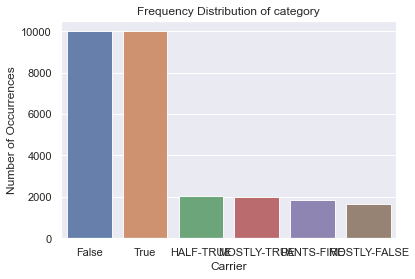

In [6]:
%matplotlib inline
carrier_count = df["label"].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of category')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Carrier', fontsize=12)
plt.show()

## Removing Null Values 

In [7]:
df=data.dropna( axis=0, how="any", thresh=None, subset=None, inplace=False)

## Checking Null Values

In [8]:
df.isnull().sum()

headline    0
text        0
label       0
dtype: int64

In [9]:
df.shape

(27565, 3)

## Combining Title and Text 

In [10]:
df['News Content'] = df['headline'] +' '+ df['text']
df.head()

,headline,text,label,News Content
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,True,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,True,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,True,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,True,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,True,Trump wants Postal Service to charge 'much mor...


In [11]:
df.tail()

,headline,text,label,News Content
27560,President and First Lady Arrive in Texas: Serv...,Check out what s happening in Texas! President...,False,President and First Lady Arrive in Texas: Serv...
27561,Heaven’s Gatekeeper? Jesse Jackson Proclaims T...,Jesse Jackson thinks he s Heaven s gatekeeper ...,False,Heaven’s Gatekeeper? Jesse Jackson Proclaims T...
27562,First Lady Melania Trump Defies Critics…Rocks ...,The media will lose it again because Melania T...,False,First Lady Melania Trump Defies Critics…Rocks ...
27563,Watch Women’s March Activist: ‘Missing Black G...,Unbelievable! Women s March Activist went off ...,False,Watch Women’s March Activist: ‘Missing Black G...
27564,Classic! Kid Rock Hits Back At false News And ...,Not much to say after this classic response fr...,False,Classic! Kid Rock Hits Back At false News And ...


## Randomize data

In [12]:
df=df.sample(frac=1)

In [13]:
df.head()

,headline,text,label,News Content
3821,"Trump says 'his decision' to fire FBI chief, c...",WASHINGTON (Reuters) - President Donald Trump ...,True,"Trump says 'his decision' to fire FBI chief, c..."
14621,"No, voucher schools haven't raised property ta...","The system, which uses taxpayer money to send ...",MOSTLY-FALSE,"No, voucher schools haven't raised property ta..."
19624,Cowardly GOP Rep. Files Police Complaint Agai...,"Republican members of Congress, who love claim...",False,Cowardly GOP Rep. Files Police Complaint Agai...
3686,Congressional office to release House healthca...,WASHINGTON (Reuters) - The Congressional Budge...,True,Congressional office to release House healthca...
22595,Trump Gets Called Out: Khizr Khan And Harry R...,"In a speech on Monday, Donald Trump proposed a...",False,Trump Gets Called Out: Khizr Khan And Harry R...


In [14]:
df.tail()

,headline,text,label,News Content
15536,Are the 'overwhelming majority of violent crim...,It came after Hewitt brought up the shooting a...,MOSTLY-FALSE,Are the 'overwhelming majority of violent crim...
12140,Fact-checking Biden’s claim about number of st...,Former Vice President Joe Biden campaigned wit...,HALF-TRUE,Fact-checking Biden’s claim about number of st...
17675,GOP Senate Candidate Turns Out To Be A Disgus...,The Republican favorite in Alabama s Senate ra...,False,GOP Senate Candidate Turns Out To Be A Disgus...
2212,Trump says will speak with China's Xi on North...,WASHINGTON (Reuters) - President Donald Trump ...,True,Trump says will speak with China's Xi on North...
21361,Woman Gets Death Threats Just For Posting A P...,"After last week s election, Hillary supporters...",False,Woman Gets Death Threats Just For Posting A P...


## Selecting Required Columns

In [15]:
df=df[['News Content','label']]
df.head()

,News Content,label
3821,"Trump says 'his decision' to fire FBI chief, c...",True
14621,"No, voucher schools haven't raised property ta...",MOSTLY-FALSE
19624,Cowardly GOP Rep. Files Police Complaint Agai...,False
3686,Congressional office to release House healthca...,True
22595,Trump Gets Called Out: Khizr Khan And Harry R...,False


### Cleaning data

In [16]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [17]:
df["News Content"] = df["News Content"].apply(wordopt)

In [18]:
df.head()

,News Content,label
3821,trump says his decision to fire fbi chief c...,True
14621,no voucher schools haven t raised property ta...,MOSTLY-FALSE
19624,cowardly gop rep files police complaint agai...,False
3686,congressional office to release house healthca...,True
22595,trump gets called out khizr khan and harry r...,False


## Tokenization

In [19]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df["News Content"] = df["News Content"].apply(tokenizer.tokenize)

In [20]:
df.head()

,News Content,label
3821,"[trump, says, his, decision, to, fire, fbi, ch...",True
14621,"[no, voucher, schools, haven, t, raised, prope...",MOSTLY-FALSE
19624,"[cowardly, gop, rep, files, police, complaint,...",False
3686,"[congressional, office, to, release, house, he...",True
22595,"[trump, gets, called, out, khizr, khan, and, h...",False


## Removing stop words

In [21]:
stopwords=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text=[word for word in text if word not in stopwords]
    return text

In [22]:
df['News Content']=df['News Content'].apply(lambda x:remove_stopwords(x))
df.head()

,News Content,label
3821,"[trump, says, decision, fire, fbi, chief, call...",True
14621,"[voucher, schools, raised, property, taxes, si...",MOSTLY-FALSE
19624,"[cowardly, gop, rep, files, police, complaint,...",False
3686,"[congressional, office, release, house, health...",True
22595,"[trump, gets, called, khizr, khan, harry, reid...",False


## Lemmatization

In [23]:
wn= nltk.WordNetLemmatizer()
def lemmatization(text):
    text=[wn.lemmatize(word) for word in text]
    return text

In [24]:
df['News Content']=df['News Content'].apply(lambda x:lemmatization(x))
df.head()

,News Content,label
3821,"[trump, say, decision, fire, fbi, chief, call,...",True
14621,"[voucher, school, raised, property, tax, since...",MOSTLY-FALSE
19624,"[cowardly, gop, rep, file, police, complaint, ...",False
3686,"[congressional, office, release, house, health...",True
22595,"[trump, get, called, khizr, khan, harry, reid,...",False


## Features Extraction

# Count Vectorization 

In [25]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2))
X = vectorizer.fit_transform(df['News Content'].astype('str'))
print(vectorizer.get_feature_names())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Label Encoding

In [26]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
df["encoded_label"] = labelencoder.fit_transform(df['label'].astype(str)) 

In [27]:
df

,News Content,label,encoded_label
3821,"[trump, say, decision, fire, fbi, chief, call,...",True,5
14621,"[voucher, school, raised, property, tax, since...",MOSTLY-FALSE,2
19624,"[cowardly, gop, rep, file, police, complaint, ...",False,0
3686,"[congressional, office, release, house, health...",True,5
22595,"[trump, get, called, khizr, khan, harry, reid,...",False,0
...,...,...,...
15536,"[overwhelming, majority, violent, criminal, de...",MOSTLY-FALSE,2
12140,"[fact, checking, biden, claim, number, student...",HALF-TRUE,1
17675,"[gop, senate, candidate, turn, disgusting, chi...",False,0
2212,"[trump, say, speak, china, xi, north, korea, f...",True,5


In [28]:
df.to_csv("preprocessed.csv")

## Feature selection from the extracted features of unigram

In [29]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest


selector = SelectKBest(chi2, k=100)
selector.fit(X, df['encoded_label'])

bigramdata = selector.transform(X)
print(X.shape)

(27565, 2990677)


# Dependent and Independent

In [30]:
X=bigramdata
y=np.array(df['encoded_label'])

# K-Fold

In [31]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(X)
print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)


In [32]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 2757  2758  2759 ... 27562 27563 27564] TEST: [   0    1    2 ... 2754 2755 2756]
TRAIN: [    0     1     2 ... 27562 27563 27564] TEST: [2757 2758 2759 ... 5511 5512 5513]
TRAIN: [    0     1     2 ... 27562 27563 27564] TEST: [5514 5515 5516 ... 8268 8269 8270]
TRAIN: [    0     1     2 ... 27562 27563 27564] TEST: [ 8271  8272  8273 ... 11025 11026 11027]
TRAIN: [    0     1     2 ... 27562 27563 27564] TEST: [11028 11029 11030 ... 13782 13783 13784]
TRAIN: [    0     1     2 ... 27562 27563 27564] TEST: [13785 13786 13787 ... 16538 16539 16540]
TRAIN: [    0     1     2 ... 27562 27563 27564] TEST: [16541 16542 16543 ... 19294 19295 19296]
TRAIN: [    0     1     2 ... 27562 27563 27564] TEST: [19297 19298 19299 ... 22050 22051 22052]
TRAIN: [    0     1     2 ... 27562 27563 27564] TEST: [22053 22054 22055 ... 24806 24807 24808]
TRAIN: [    0     1     2 ... 24806 24807 24808] TEST: [24809 24810 24811 ... 27562 27563 27564]


# Models Training

## Multinomial NB

In [33]:
from sklearn.naive_bayes import MultinomialNB
nab=MultinomialNB()
nab= nab.fit(X_train,y_train)
pred=nab.predict(X_test)
print(classification_report(y_test, pred))
nab_accuracy = round((accuracy_score(y_test, pred)*100),2)

print("Accuracy : " , nab_accuracy , " %")

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       983
           1       0.91      0.94      0.93       202
           2       0.96      0.75      0.84       176
           3       0.80      0.94      0.86       209
           4       0.91      0.96      0.93       204
           5       0.97      0.98      0.97       982

    accuracy                           0.95      2756
   macro avg       0.92      0.92      0.92      2756
weighted avg       0.95      0.95      0.95      2756

Accuracy :  95.03  %


<AxesSubplot:>

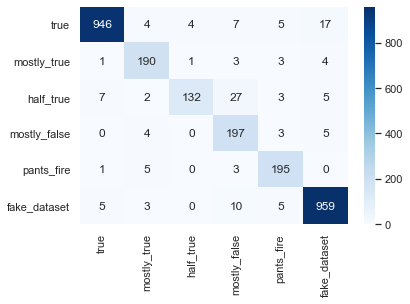

In [34]:
matrix =confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(matrix, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

# Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth=2,random_state=0)
rf=rf.fit(X_train,np.ravel(y_train))
pred1=rf.predict(X_test)
print(classification_report(y_test, pred1))
rf_accuracy = round((accuracy_score(y_test, pred1)*100),2)
print("Accuracy : " , rf_accuracy , " %")

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       983
           1       1.00      0.07      0.14       202
           2       1.00      0.35      0.52       176
           3       1.00      0.81      0.89       209
           4       1.00      0.29      0.45       204
           5       0.65      1.00      0.79       982

    accuracy                           0.79      2756
   macro avg       0.93      0.57      0.62      2756
weighted avg       0.86      0.79      0.76      2756

Accuracy :  79.1  %


<AxesSubplot:>

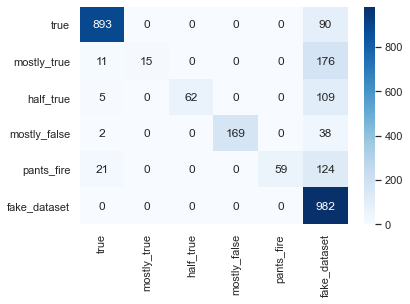

In [36]:
matrix1 =confusion_matrix(y_test, pred1)
df_cm = pd.DataFrame(matrix1, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

# Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0) 
dt.fit(X_train,np.ravel(y_train)) 
pred2=dt.predict(X_test)
print(classification_report(y_test, pred2))
print(confusion_matrix(y_test, pred2))


dt_accuracy = round((accuracy_score(y_test, pred2)*100),2)

print("Accuracy : " , dt_accuracy , " %")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.98      0.97      0.98       202
           2       0.96      0.99      0.97       176
           3       0.99      0.95      0.97       209
           4       0.98      0.97      0.97       204
           5       0.99      1.00      1.00       982

    accuracy                           0.99      2756
   macro avg       0.98      0.98      0.98      2756
weighted avg       0.99      0.99      0.99      2756

[[972   0   2   1   4   4]
 [  2 196   2   1   1   0]
 [  1   0 174   1   0   0]
 [  4   3   2 199   0   1]
 [  5   0   1   0 198   0]
 [  0   0   0   0   0 982]]
Accuracy :  98.73  %


<AxesSubplot:>

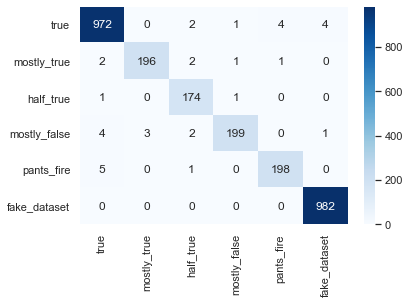

In [38]:
matrix2 =confusion_matrix(y_test, pred2)
df_cm = pd.DataFrame(matrix2, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

## SVM

In [39]:
from sklearn import svm
svm = svm.LinearSVC() 
svm.fit(X_train,np.ravel(y_train)) 
pred3=svm.predict(X_test)
print(classification_report(y_test, pred3))
print(confusion_matrix(y_test, pred3))


svm_accuracy = round((accuracy_score(y_test, pred3)*100),2)

print("Accuracy : " , svm_accuracy , " %")

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       983
           1       0.98      0.98      0.98       202
           2       0.98      0.99      0.99       176
           3       0.99      0.95      0.97       209
           4       1.00      0.98      0.99       204
           5       1.00      1.00      1.00       982

    accuracy                           0.99      2756
   macro avg       0.99      0.98      0.99      2756
weighted avg       0.99      0.99      0.99      2756

[[982   1   0   0   0   0]
 [  2 197   2   0   0   1]
 [  0   0 175   1   0   0]
 [  7   3   1 198   0   0]
 [  4   0   0   0 200   0]
 [  0   0   0   0   0 982]]
Accuracy :  99.2  %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<AxesSubplot:>

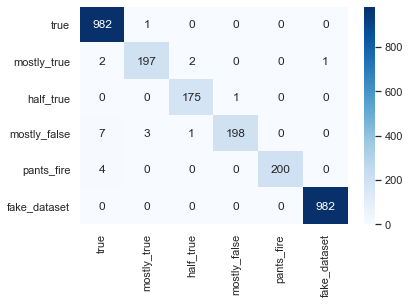

In [40]:
matrix3 =confusion_matrix(y_test, pred3)
df_cm = pd.DataFrame(matrix3, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

In [41]:
pickle.dump(svm, open('SVM_model.pkl', 'wb'))

# Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
lg=LogisticRegression()
lg.fit(X_train,np.ravel(y_train)) 
pred4=lg.predict(X_test)
print(classification_report(y_test, pred4))
print(confusion_matrix(y_test, pred4))


lg_accuracy = round((accuracy_score(y_test, pred4)*100),2)

print("Accuracy : " , lg_accuracy , " %")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.98      0.97      0.98       202
           2       0.98      0.99      0.99       176
           3       0.99      0.96      0.98       209
           4       0.99      0.98      0.98       204
           5       1.00      1.00      1.00       982

    accuracy                           0.99      2756
   macro avg       0.99      0.98      0.98      2756
weighted avg       0.99      0.99      0.99      2756

[[978   1   1   2   0   1]
 [  2 196   2   0   1   1]
 [  0   0 175   0   1   0]
 [  4   2   1 201   1   0]
 [  4   1   0   0 199   0]
 [  0   0   0   0   0 982]]
Accuracy :  99.09  %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:>

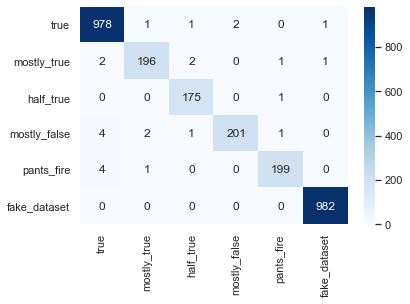

In [43]:
matrix4 =confusion_matrix(y_test, pred4)
df_cm = pd.DataFrame(matrix4, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

In [44]:
pickle.dump(lg, open('Logistic_Regression_model.pkl', 'wb'))

# Gradient Boosting Classifier

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
gbc.fit(X_train, y_train) 
pred5=gbc.predict(X_test)
print(classification_report(y_test, pred5))
print(confusion_matrix(y_test, pred5))


gbc_accuracy = round((accuracy_score(y_test, pred5)*100),2)

print("Accuracy : " , gbc_accuracy , " %")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       983
           1       0.98      0.97      0.98       202
           2       1.00      0.99      0.99       176
           3       0.99      0.93      0.96       209
           4       0.99      0.97      0.98       204
           5       1.00      1.00      1.00       982

    accuracy                           0.99      2756
   macro avg       0.99      0.98      0.98      2756
weighted avg       0.99      0.99      0.99      2756

[[981   0   0   0   1   1]
 [  4 196   0   1   0   1]
 [  2   0 174   0   0   0]
 [ 10   3   0 195   1   0]
 [  7   0   0   0 197   0]
 [  0   0   0   0   0 982]]
Accuracy :  98.88  %


<AxesSubplot:>

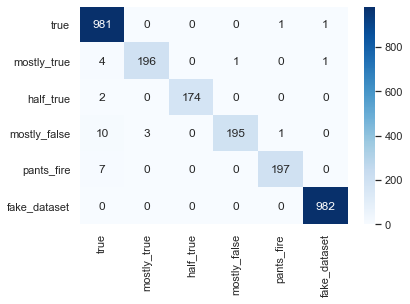

In [46]:
matrix5 =confusion_matrix(y_test, pred5)
df_cm = pd.DataFrame(matrix5, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

### Ensemble Techniques

In [47]:
from imblearn.ensemble import EasyEnsembleClassifier

In [48]:
easy=EasyEnsembleClassifier()
easy.fit(X_train,y_train)

EasyEnsembleClassifier()

In [49]:
pred6=easy.predict(X_test)
print(confusion_matrix(y_test,pred6))
print(accuracy_score(y_test,pred6))
print(classification_report(y_test,pred6))
ensemble_accuracy = round((accuracy_score(y_test, pred6)*100),2)

print("Accuracy : " , ensemble_accuracy , " %")

[[970   5   2   1   0   5]
 [  0 198   3   1   0   0]
 [  0   1 175   0   0   0]
 [  1   7   2 199   0   0]
 [  2   2   0   1 199   0]
 [  0   0   0   0   0 982]]
0.9880261248185777
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       983
           1       0.93      0.98      0.95       202
           2       0.96      0.99      0.98       176
           3       0.99      0.95      0.97       209
           4       1.00      0.98      0.99       204
           5       0.99      1.00      1.00       982

    accuracy                           0.99      2756
   macro avg       0.98      0.98      0.98      2756
weighted avg       0.99      0.99      0.99      2756

Accuracy :  98.8  %


<AxesSubplot:>

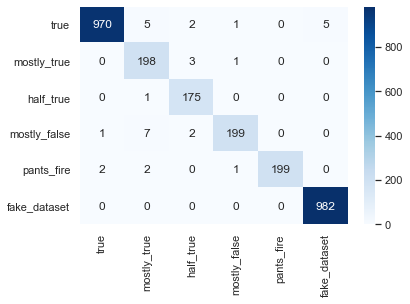

In [50]:
matrix6 =confusion_matrix(y_test, pred6)
df_cm = pd.DataFrame(matrix6, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

# Accuracies

In [51]:
Models = pd.DataFrame({
    'Models': ['MultinomialNB','Random Forest','Decision Tree','SVM','Logistic Regression','Gradient Boosting Classifier','Easy Ensembling Classifier'],
    
    'Accuracies': np.round([nab_accuracy,rf_accuracy,dt_accuracy,svm_accuracy,lg_accuracy,gbc_accuracy,ensemble_accuracy],2)
                     })
print('Rank of models by Accuracies ')
Models.sort_values(by=['Accuracies'],ascending=False)

Rank of models by Accuracies 


,Models,Accuracies
3,SVM,99.20
4,Logistic Regression,99.09
5,Gradient Boosting Classifier,98.88
6,Easy Ensembling Classifier,98.80
2,Decision Tree,98.73
0,MultinomialNB,95.03
1,Random Forest,79.10


# Imbalance data Techniques

### Weight changing via Balanced approach

In [52]:
from sklearn import svm
weight = svm.LinearSVC( class_weight='balanced')
weight.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(class_weight='balanced')

In [53]:
y_pred0=weight.predict(X_test)
print(confusion_matrix(y_test,y_pred0))
print(accuracy_score(y_test,y_pred0))
print(classification_report(y_test,y_pred0))
Bweight_changing_accuracy = round((accuracy_score(y_test, y_pred0)*100),2)
print("Accuracy : " , Bweight_changing_accuracy , " %")

[[980   1   1   0   1   0]
 [  2 197   2   0   0   1]
 [  0   0 175   0   1   0]
 [  3   3   1 201   1   0]
 [  4   0   0   0 200   0]
 [  0   0   0   0   0 982]]
0.9923802612481858
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       983
           1       0.98      0.98      0.98       202
           2       0.98      0.99      0.99       176
           3       1.00      0.96      0.98       209
           4       0.99      0.98      0.98       204
           5       1.00      1.00      1.00       982

    accuracy                           0.99      2756
   macro avg       0.99      0.98      0.99      2756
weighted avg       0.99      0.99      0.99      2756

Accuracy :  99.24  %


<AxesSubplot:>

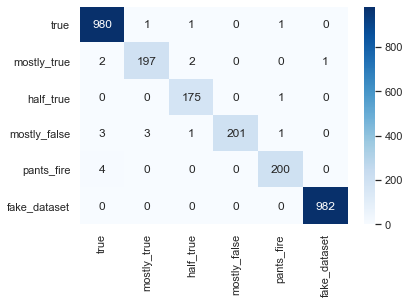

In [54]:
matrix7 =confusion_matrix(y_test, y_pred0)
df_cm = pd.DataFrame(matrix7, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

In [83]:
pickle.dump(weight, open('balanced_weight_model.pkl', 'wb'))

# Manual Weight Change

In [55]:
Mweight=svm.LinearSVC( class_weight={0:5,1:1,2:1,3:1,4:1,5:5})
Mweight.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(class_weight={0: 5, 1: 1, 2: 1, 3: 1, 4: 1, 5: 5})

In [56]:
y_pred1=Mweight.predict(X_test)
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))
Mweight_changing_accuracy = round((accuracy_score(y_test, y_pred1)*100),2)

print("Accuracy : " , Mweight_changing_accuracy , " %")

[[982   1   0   0   0   0]
 [  2 197   2   0   0   1]
 [  1   0 175   0   0   0]
 [  8   2   1 197   1   0]
 [  6   0   0   0 198   0]
 [  0   0   0   0   0 982]]
0.9909288824383164
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       983
           1       0.98      0.98      0.98       202
           2       0.98      0.99      0.99       176
           3       1.00      0.94      0.97       209
           4       0.99      0.97      0.98       204
           5       1.00      1.00      1.00       982

    accuracy                           0.99      2756
   macro avg       0.99      0.98      0.99      2756
weighted avg       0.99      0.99      0.99      2756

Accuracy :  99.09  %


<AxesSubplot:>

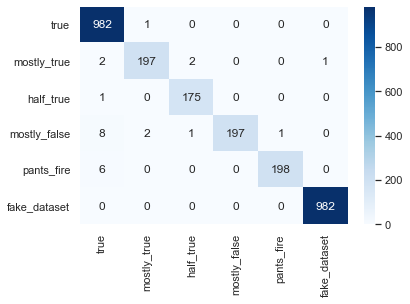

In [57]:
matrix8 =confusion_matrix(y_test, y_pred1)
df_cm = pd.DataFrame(matrix8, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

In [58]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

### Under Sampling

In [59]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler  
under_sampler = RandomUnderSampler()
X_train_ns,y_train_ns=under_sampler.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 9018, 5: 9012, 1: 1857, 3: 1775, 4: 1650, 2: 1497})
The number of classes after fit Counter({0: 1497, 1: 1497, 2: 1497, 3: 1497, 4: 1497, 5: 1497})


In [60]:
under=svm.LinearSVC()
under.fit(X_train_ns,y_train_ns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

In [61]:
y_pred2=under.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))
underSample_accuracy = round((accuracy_score(y_test, y_pred2)*100),2)

print("Accuracy : " ,underSample_accuracy , " %")

[[973   5   1   2   2   0]
 [  1 198   2   0   1   0]
 [  0   0 175   1   0   0]
 [  0   5   2 200   2   0]
 [  2   1   0   0 201   0]
 [  1   0   0   0   0 981]]
0.9898403483309144
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       983
           1       0.95      0.98      0.96       202
           2       0.97      0.99      0.98       176
           3       0.99      0.96      0.97       209
           4       0.98      0.99      0.98       204
           5       1.00      1.00      1.00       982

    accuracy                           0.99      2756
   macro avg       0.98      0.98      0.98      2756
weighted avg       0.99      0.99      0.99      2756

Accuracy :  98.98  %


<AxesSubplot:>

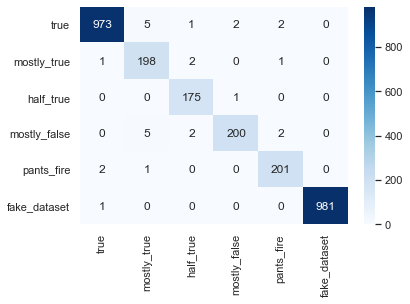

In [62]:
matrix9 =confusion_matrix(y_test, y_pred2)
df_cm = pd.DataFrame(matrix9, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

### Over Sampling

In [63]:
os=RandomOverSampler()
X_train_ns,y_train_ns=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 9018, 5: 9012, 1: 1857, 3: 1775, 4: 1650, 2: 1497})
The number of classes after fit Counter({5: 9018, 2: 9018, 0: 9018, 1: 9018, 4: 9018, 3: 9018})


In [64]:
over=svm.LinearSVC()
over.fit(X_train_ns,y_train_ns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

In [65]:
y_pred3=over.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))
overSample_accuracy = round((accuracy_score(y_test, y_pred3)*100),2)

print("Accuracy : " , overSample_accuracy , " %")

[[972   6   1   0   4   0]
 [  2 197   2   0   0   1]
 [  0   0 175   0   1   0]
 [  1   6   1 200   1   0]
 [  3   1   0   0 200   0]
 [  0   0   0   0   0 982]]
0.9891146589259797
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.94      0.98      0.96       202
           2       0.98      0.99      0.99       176
           3       1.00      0.96      0.98       209
           4       0.97      0.98      0.98       204
           5       1.00      1.00      1.00       982

    accuracy                           0.99      2756
   macro avg       0.98      0.98      0.98      2756
weighted avg       0.99      0.99      0.99      2756

Accuracy :  98.91  %


<AxesSubplot:>

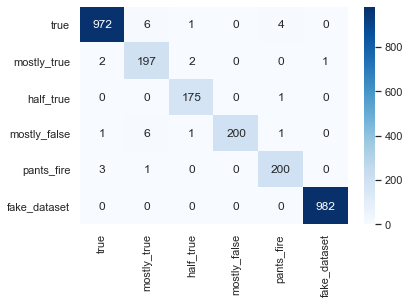

In [66]:
matrix10 =confusion_matrix(y_test, y_pred3)
df_cm = pd.DataFrame(matrix10, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

# SmoteTomek

In [67]:
smote=svm.LinearSVC()
smote.fit(X_train_ns,y_train_ns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

In [68]:
y_pred8=smote.predict(X_test)
print(confusion_matrix(y_test,y_pred8))
print(accuracy_score(y_test,y_pred8))
print(classification_report(y_test,y_pred8))
smote_accuracy = round((accuracy_score(y_test, y_pred8)*100),2)

print("Accuracy : " , smote_accuracy , " %")

[[973   5   1   0   4   0]
 [  2 197   3   0   0   0]
 [  0   0 175   0   1   0]
 [  0   5   2 200   2   0]
 [  3   1   0   0 200   0]
 [  0   0   0   0   0 982]]
0.989477503628447
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.95      0.98      0.96       202
           2       0.97      0.99      0.98       176
           3       1.00      0.96      0.98       209
           4       0.97      0.98      0.97       204
           5       1.00      1.00      1.00       982

    accuracy                           0.99      2756
   macro avg       0.98      0.98      0.98      2756
weighted avg       0.99      0.99      0.99      2756

Accuracy :  98.95  %


<AxesSubplot:>

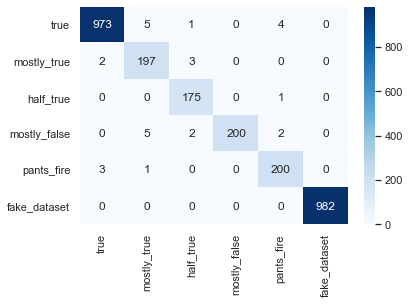

In [69]:
matrix11 =confusion_matrix(y_test, y_pred8)
df_cm = pd.DataFrame(matrix11, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

### Cross Validation Like KFOLD and Hyperparameter Tuning

In [70]:
from sklearn.model_selection import GridSearchCV

In [71]:
svm = svm.LinearSVC()  
grid={'C':10.0 **np.arange(-2,3),'penalty':['l1','l2']}
cv=KFold(n_splits=10,random_state=None,shuffle=False)

In [72]:
clf=GridSearchCV(svm,grid,cv=cv,n_jobs=-1,scoring='f1_macro')
clf.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.98256624        nan 0.98250108        nan 0.98275647
        nan 0.98239787        nan 0.97727534]
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [73]:
y_pred9=clf.predict(X_test)
print(confusion_matrix(y_test,y_pred9))
print(accuracy_score(y_test,y_pred9))
print(classification_report(y_test,y_pred9))
clf_accuracy = round((accuracy_score(y_test, y_pred9)*100),2)
print("Accuracy : " , clf_accuracy , " %")

[[982   1   0   0   0   0]
 [  2 197   2   0   0   1]
 [  0   0 175   1   0   0]
 [  7   3   1 198   0   0]
 [  4   0   0   0 200   0]
 [  0   0   0   0   0 982]]
0.9920174165457184
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       983
           1       0.98      0.98      0.98       202
           2       0.98      0.99      0.99       176
           3       0.99      0.95      0.97       209
           4       1.00      0.98      0.99       204
           5       1.00      1.00      1.00       982

    accuracy                           0.99      2756
   macro avg       0.99      0.98      0.99      2756
weighted avg       0.99      0.99      0.99      2756

Accuracy :  99.2  %


<AxesSubplot:>

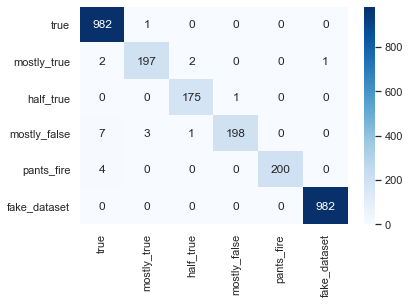

In [74]:
matrix12 =confusion_matrix(y_test, y_pred9)
df_cm = pd.DataFrame(matrix12, columns=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'], index=['true', 'mostly_true','half_true','mostly_false','pants_fire','fake_dataset'])
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

# Accuracies of models using imbalance techniques

In [75]:
Models = pd.DataFrame({
    'Models': ['Balanced_weight Change','Under Sampling','Over Sampling','Manual_weight Change','SMOTETomek'],
    
    'Accuracies': np.round([Bweight_changing_accuracy,underSample_accuracy,overSample_accuracy,Mweight_changing_accuracy,smote_accuracy],2)
                     })
print('Rank of models by Accuracies ')
Models.sort_values(by=['Accuracies'],ascending=False) 

Rank of models by Accuracies 


,Models,Accuracies
0,Balanced_weight Change,99.24
3,Manual_weight Change,99.09
1,Under Sampling,98.98
4,SMOTETomek,98.95
2,Over Sampling,98.91


# Accuracies of models without imbalance techniques

In [76]:
Models = pd.DataFrame({
    'Models': ['MultinomialNB','Random Forest','Decision Tree','SVM','Logistic Regression','Gradient Boosting Classifier','Easy Ensembling Classifier','SVM Hyperparameter Tunning'],
    
    'Accuracies': np.round([nab_accuracy,rf_accuracy,dt_accuracy,svm_accuracy,lg_accuracy,gbc_accuracy,ensemble_accuracy,clf_accuracy],2)
                     })
print('Rank of models by Accuracies ')
Models.sort_values(by=['Accuracies'],ascending=False)

Rank of models by Accuracies 


,Models,Accuracies
3,SVM,99.20
7,SVM Hyperparameter Tunning,99.20
4,Logistic Regression,99.09
5,Gradient Boosting Classifier,98.88
6,Easy Ensembling Classifier,98.80
2,Decision Tree,98.73
0,MultinomialNB,95.03
1,Random Forest,79.10


# Taking user input in the form of url

In [77]:
url_input = input("\nPlease enter URL of news article here  : ").strip()


Please enter URL of news article here  : https://www.politifact.com/factchecks/2022/jan/13/joe-biden/evidence-scant-joe-biden-was-arrested-protesting-c/


In [84]:
from newspaper import Article
url = url_input
article = Article(url)
article.download()
article.html
article.parse()
title = article.title
text = article.text

In [79]:
news = title +' '+text
news=[news]
news

['Evidence scant that Joe Biden was arrested protesting for civil rights • However, there is no evidence that Biden was actually arrested in either the legal sense or in how ordinary listeners would be likely to understand that term. At times, Biden himself has described the police’s actions as driving him home, rather than putting him under arrest.\n\n• Biden may have participated in one of two flare-ups over racial discrimination in housing near his home in Delaware when he was a teenager.\n\nWhen President Joe Biden went to Georgia to press for voting rights legislation, he made a passing reference to a moment from his past — the time he "got arrested" while protesting for civil rights.\n\nIt’s not the first time Biden has said he was arrested in his youth while protesting for civil rights. And it’s not the first time that the evidence to back up his assertion is scarce. He’s been called out repeatedly for decades by fact-checkers, including PolitiFact, for exaggerating his experien

In [80]:
word_vectorizer = CountVectorizer(
    lowercase=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features =100)
unigramdataGet= word_vectorizer.fit_transform(news)
unigramdata = unigramdataGet.toarray()
unigramdata

array([[ 3,  3,  4,  3, 11,  3, 18,  3,  5,  2, 42,  2,  3,  3,  2,  3,
         6,  2,  2,  9,  5,  3,  3, 10, 10,  3,  3,  3,  6,  4,  4,  4,
         2,  3,  3,  3,  3,  2,  2,  7,  3,  4,  2,  5,  4, 20,  2,  2,
         2,  3,  3,  4,  3,  3,  3,  4,  2,  2,  3,  3,  3,  4, 14,  4,
         3,  4,  4,  3,  2,  3,  3,  2,  2,  3,  3, 11,  3, 14,  3, 18,
         3,  3,  3,  4,  2,  2,  2,  2,  2,  4,  3,  3,  7,  3,  5,  5,
         3,  3,  3,  3]], dtype=int64)

In [81]:
model=pickle.load(open('SVM_model.pkl', 'rb'))

In [82]:
predicted = model.predict(unigramdata)
if(predicted == 0):
    prediction = "true" 
if(predicted == 1):
    prediction = "mostly true"
if(predicted == 2):
    prediction = "half true" 
if(predicted == 3):
    prediction = "mostly false"
if(predicted == 4):
    prediction = "pants fire" 
if(predicted == 5):
    prediction = "false"
print(prediction)

pants fire
